In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.covariance import LedoitWolf
import statsmodels.api as sm
from statsmodels.nonparametric.kernel_regression import KernelReg
import scipy.stats as stats
from scipy.stats import shapiro, wilcoxon, mannwhitneyu
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.linalg import inv
from scipy.spatial.distance import mahalanobis
from scipy.linalg import hilbert

In [2]:
seed = 26
np.random.seed(seed)

# Punto 1

## Grafica de la funcion resultante
$E(Y|X) = \frac{x + \frac{4}{3}}{x + 1}$

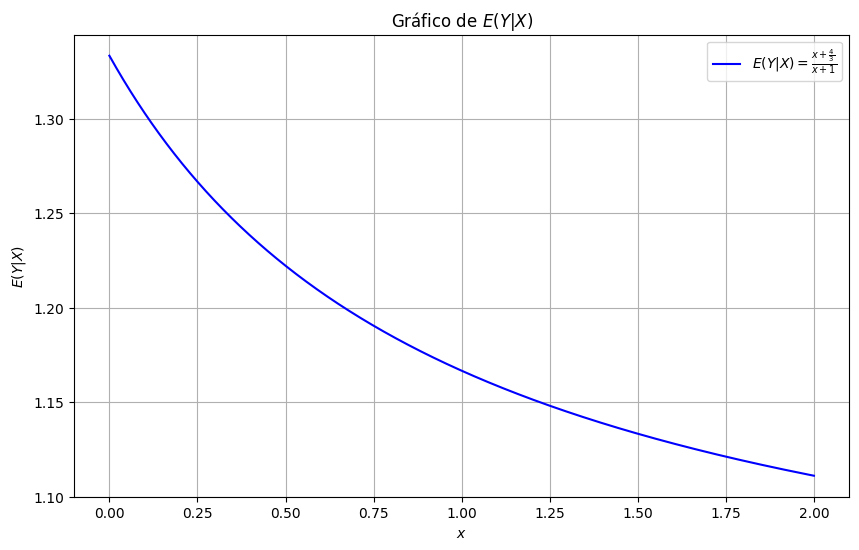

In [3]:
def expected_y_given_x(x):
    return (x + 4/3) / (x + 1)

# Generar 1000 puntos para x en el rango de 0 a 2
x_values = np.linspace(0, 2, 1000)
y_values = expected_y_given_x(x_values)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label=r'$E(Y|X) = \frac{x + \frac{4}{3}}{x + 1}$', color='blue')
plt.title('Gráfico de $E(Y|X)$')
plt.xlabel('$x$')
plt.ylabel('$E(Y|X)$')
plt.grid(True)
plt.legend()
plt.show()


## Grafica ruido agregado y datos simulados

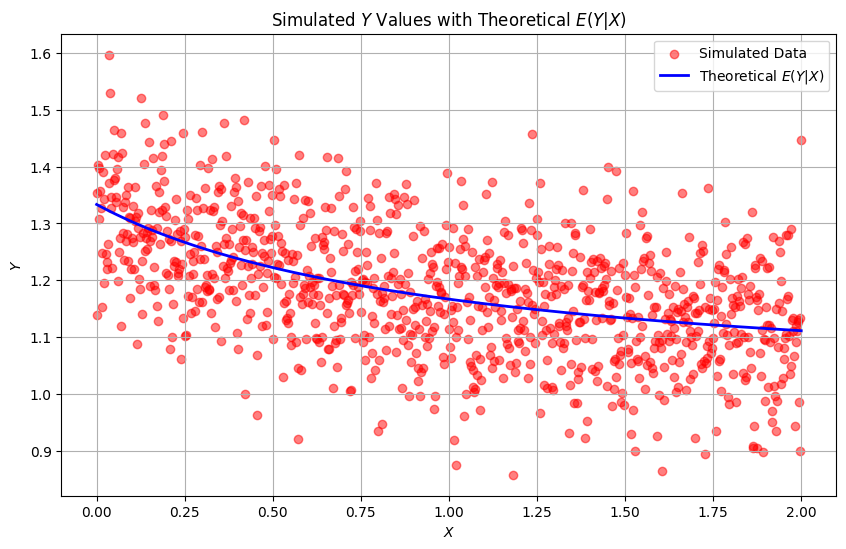

In [4]:
# Calcular los valores teóricos de Y
y_theoretical = expected_y_given_x(x_values)

# Agregar ruido blanco gaussiano con desviación estándar de 0.1
noise = np.random.normal(0, 0.1, 1000)
y_simulated = y_theoretical + noise

# Grafica
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_simulated, alpha=0.5, label='Simulated Data', color='red')
plt.plot(x_values, y_theoretical, label='Theoretical $E(Y|X)$', color='blue', linewidth=2)
plt.title('Simulated $Y$ Values with Theoretical $E(Y|X)$')
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.legend()
plt.grid(True)
plt.show()


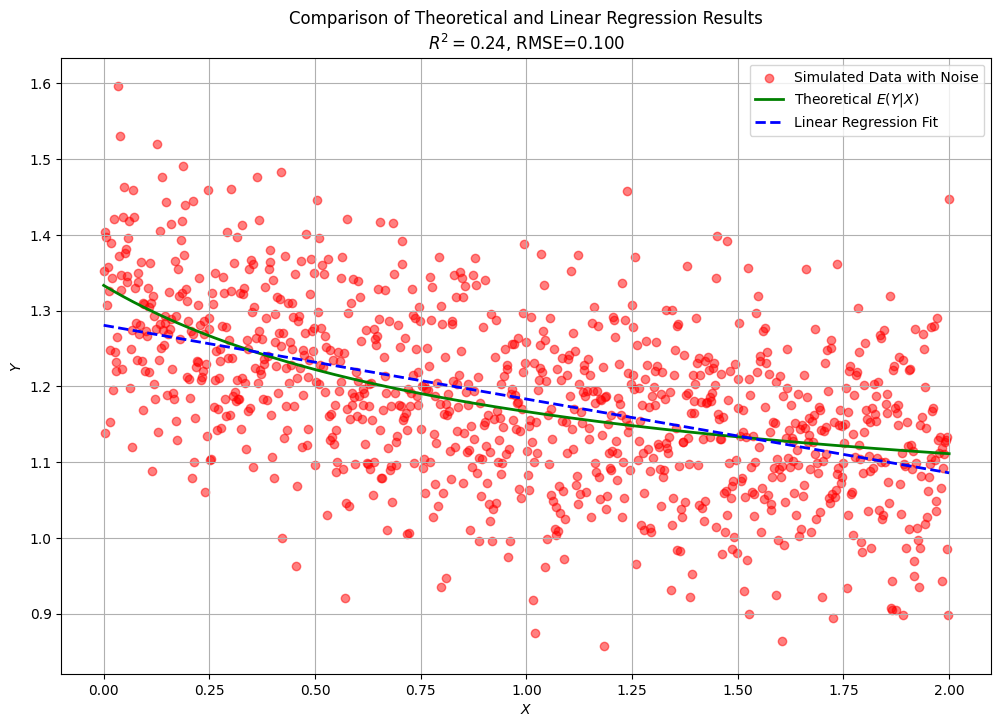

In [5]:
X = x_values.reshape(-1, 1)
Y = y_simulated

#modelo de regresión lineal
model = LinearRegression()
model.fit(X, Y)
y_predicted = model.predict(X)

# Calcular R^2 y RMSE
r2 = r2_score(Y, y_predicted)
rmse = np.sqrt(mean_squared_error(Y, y_predicted))

# Graficar los resultados
plt.figure(figsize=(12, 8))
plt.scatter(X, Y, color='red', alpha=0.5, label='Simulated Data with Noise')
plt.plot(X, y_theoretical, 'g-', label='Theoretical $E(Y|X)$', linewidth=2)
plt.plot(X, y_predicted, 'b--', label='Linear Regression Fit', linewidth=2)
plt.title('Comparison of Theoretical and Linear Regression Results\n$R^2={:.2f}$, RMSE={:.3f}'.format(r2, rmse))
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.legend()
plt.grid(True)
plt.show()


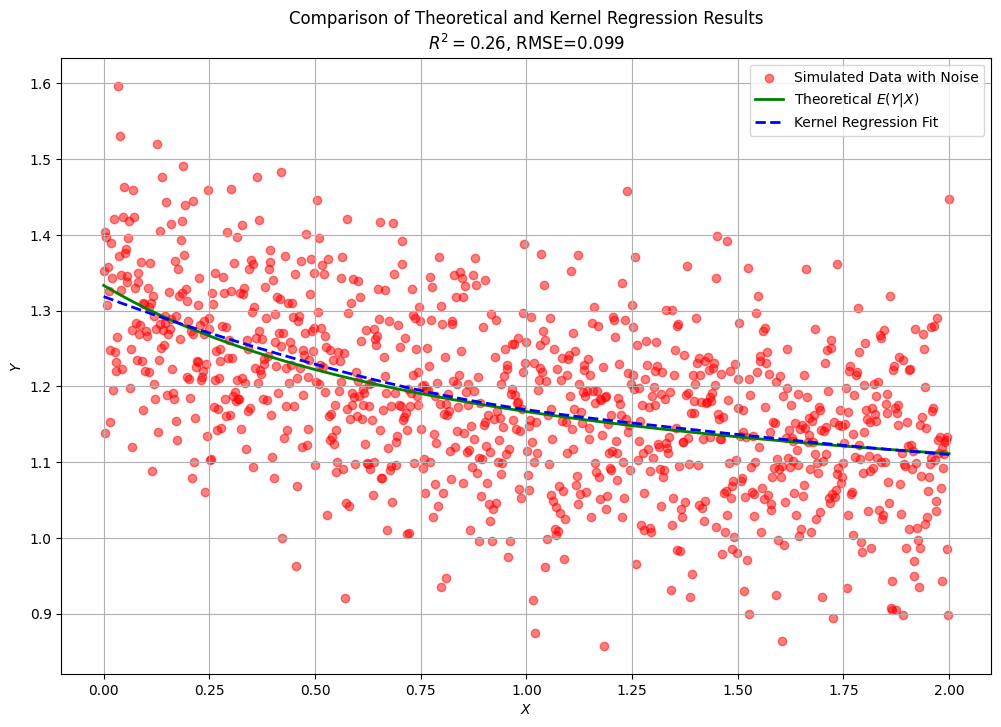

In [6]:
# Modelo KernelReg
model = KernelReg(endog=Y, exog=X, var_type='c')
y_predicted, y_std = model.fit(X)

# Calcular R^2 y RMSE
r2 = r2_score(Y, y_predicted)
rmse = np.sqrt(mean_squared_error(Y, y_predicted))

# Graficar los resultados
plt.figure(figsize=(12, 8))
plt.scatter(X, Y, color='red', alpha=0.5, label='Simulated Data with Noise')
plt.plot(X, y_theoretical, 'g-', label='Theoretical $E(Y|X)$', linewidth=2)
plt.plot(X, y_predicted, 'b--', label='Kernel Regression Fit', linewidth=2)
plt.title('Comparison of Theoretical and Kernel Regression Results\n$R^2={:.2f}$, RMSE={:.3f}'.format(r2, rmse))
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.legend()
plt.grid(True)
plt.show()

#Punto 2

## Generación de datos

In [7]:
# Generar la matriz de Hilbert
n_features = 50
cov_matrix = hilbert(n_features)
cov_matrix_inv = np.linalg.inv(cov_matrix) #Inversa de la matriz de covarianza

# Generar los datos multivariantes
n_samples = 100
X = np.random.multivariate_normal(np.zeros(n_features), cov_matrix, size=n_samples)

# Variable respuesta Y
var = 0.8
media = 28

coef = np.random.rand(n_features)
perturbation = np.random.normal(media, var, n_samples) # Ruido aleatorio normal con media 28 y varianza 0.01
Y = X @ coef + perturbation

# Dividir los datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

## Numeral a

### KNN regressor con distancia de mahalanobis

Mejor valor de K: 43
Mean Squared Error (Train): 9.70589673871698
Mean Squared Error (Test): 7.872947256616214


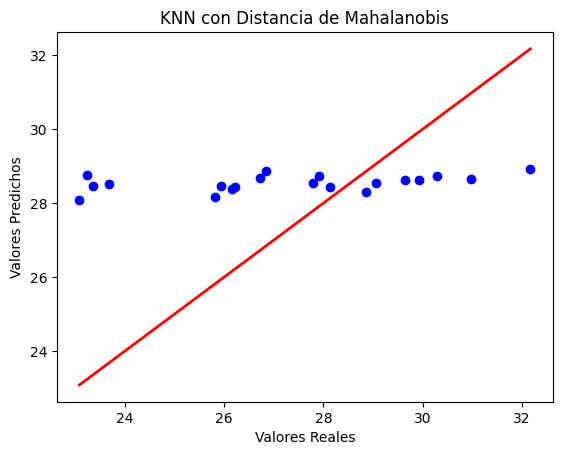

In [8]:
# Implementar KNN usando distancia de Mahalanobis
def knn_mahalanobis(X_train, Y_train, X_test, k):
    knn_regressor = KNeighborsRegressor(n_neighbors=k, metric='mahalanobis', metric_params={'VI': cov_matrix_inv})
    knn_regressor.fit(X_train, Y_train)
    Y_pred = knn_regressor.predict(X_test)
    return Y_pred

# Ajustar el valor de K
k_values = range(1, 81)
best_k = 1
best_score = float('inf')

for k in k_values:
    Y_pred = knn_mahalanobis(X_train, Y_train, X_test, k)
    mse = mean_squared_error(Y_test, Y_pred)
    if mse < best_score:
        best_score = mse
        best_k = k

# Evaluar el modelo con el mejor K
Y_pred_test = knn_mahalanobis(X_train, Y_train, X_test, best_k)
Y_pred_train = knn_mahalanobis(X_train, Y_train, X_train, best_k)

mse_test = mean_squared_error(Y_test, Y_pred_test)
mse_train = mean_squared_error(Y_train, Y_pred_train)

print(f"Mejor valor de K: {best_k}")
print(f"Mean Squared Error (Train): {mse_train}")
print(f"Mean Squared Error (Test): {mse_test}")

plt.scatter(Y_test, Y_pred_test, color='blue')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linewidth=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('KNN con Distancia de Mahalanobis')
plt.show()


## Numeral b

### KNN con Mahalanobis robustecido con la matriz de covarianza recortada
The regularised covariance is:

(1 - shrinkage) * cov + shrinkage * mu * np.identity(n_features)

where mu = trace(cov) / n_features and shrinkage is given by the Ledoit and Wolf formula (see References)

References

“A Well-Conditioned Estimator for Large-Dimensional Covariance Matrices”, Ledoit and Wolf, Journal of Multivariate Analysis, Volume 88, Issue 2, February 2004, pages 365-411.

Mejor valor de K: 4
Mean Squared Error (Train): 2.0325482067852554
Mean Squared Error (Test): 1.0436704549905946


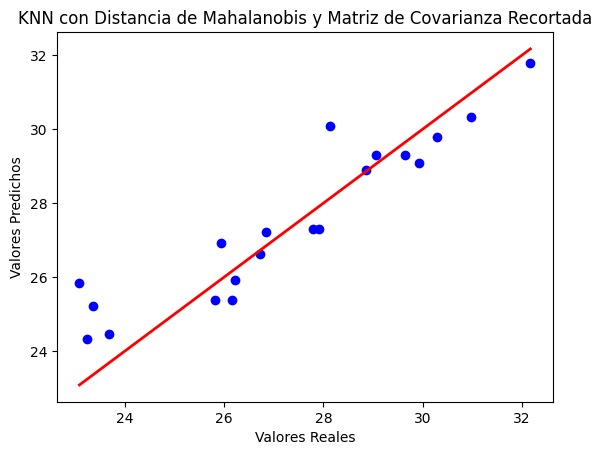

In [9]:
# Matriz de covarianza recortada usando Ledoit-Wolf
lw = LedoitWolf()
lw.fit(X_train)
cov_matrix_lw = lw.covariance_
cov_matrix_lw_inv = np.linalg.inv(cov_matrix_lw)

# Implementar KNN usando distancia de Mahalanobis con matriz de covarianza recortada
def knn_mahalanobis(X_train, Y_train, X_test, k, cov_matrix_inv):
    knn_regressor = KNeighborsRegressor(n_neighbors=k, metric='mahalanobis', metric_params={'VI': cov_matrix_lw_inv})
    knn_regressor.fit(X_train, Y_train)
    Y_pred = knn_regressor.predict(X_test)
    return Y_pred

# Ajustar el valor de K
k_values = range(1, 81)
best_k = 1
best_score = float('inf')

for k in k_values:
    Y_pred = knn_mahalanobis(X_train, Y_train, X_test, k, cov_matrix_lw_inv)
    mse = mean_squared_error(Y_test, Y_pred)
    if mse < best_score:
        best_score = mse
        best_k = k

# Evaluar el modelo con el mejor K

Y_pred_test1 = knn_mahalanobis(X_train, Y_train, X_test, best_k, cov_matrix_lw_inv)
Y_pred_train1 = knn_mahalanobis(X_train, Y_train, X_train, best_k, cov_matrix_lw_inv)

mse_test = mean_squared_error(Y_test, Y_pred_test1)
mse_train = mean_squared_error(Y_train, Y_pred_train1)

print(f"Mejor valor de K: {best_k}")
print(f"Mean Squared Error (Train): {mse_train}")
print(f"Mean Squared Error (Test): {mse_test}")

plt.scatter(Y_test, Y_pred_test1, color='blue')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linewidth=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('KNN con Distancia de Mahalanobis y Matriz de Covarianza Recortada')
plt.show()

### Modelo de regresión lineal

MSE train (Regresión Lineal): 0.309719694926437
MSE test (Regresión Lineal): 1.349517574336905


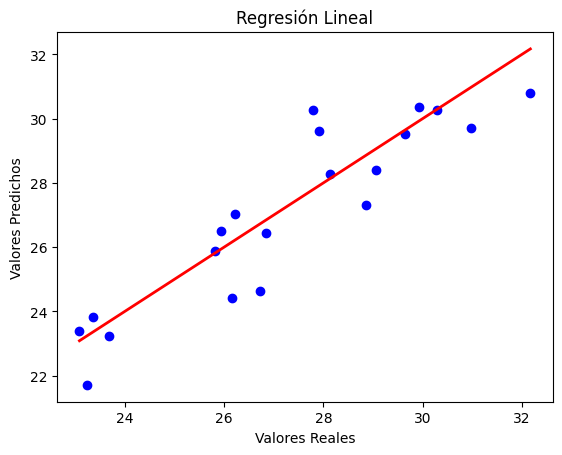

In [10]:
# Ajustar el modelo de regresión lineal
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
Y_pred_linreg = linreg.predict(X_test)
Y_pred_train = linreg.predict(X_train)
# Evaluar el modelo
mse_linreg = mean_squared_error(Y_test, Y_pred_linreg)
mse_train = mean_squared_error(Y_train, Y_pred_train)

# Resultados
print(f"MSE train (Regresión Lineal): {mse_train}")
print(f"MSE test (Regresión Lineal): {mse_linreg}")

# Visualizar los resultados
plt.scatter(Y_test, Y_pred_linreg, color='blue')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linewidth=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Regresión Lineal')
plt.show()

### Modelo de regresión robusta RLM con constante

Mean Squared Error train (Robust): 0.31214278601448064
Mean Squared Error test (Robust): 1.340700945402479


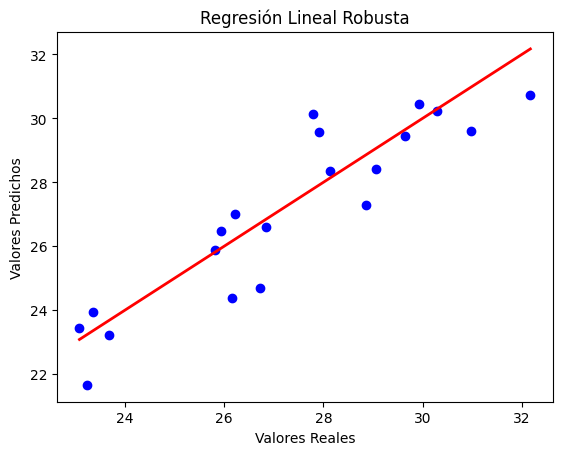

In [11]:
# Agregar una columna de unos para el intercepto en el modelo de regresión
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Ajustar el modelo de regresión lineal robusta
robust_model = sm.RLM(Y_train, X_train_const, M=sm.robust.norms.HuberT()) # Utilizar el estimador M (Huber) para la regresión
robust_results = robust_model.fit(scale_est=sm.robust.scale.HuberScale())

# Predicciones del modelo
Y_pred_robust = robust_results.predict(X_test_const)
Y_pred_train = robust_results.predict(X_train_const)

# Evaluar el modelo robusto
mse_robust = mean_squared_error(Y_test, Y_pred_robust)
mse_train = mean_squared_error(Y_train, Y_pred_train)
# Resultados
print(f"Mean Squared Error train (Robust): {mse_train}")
print(f"Mean Squared Error test (Robust): {mse_robust}")

# Visualizar los resultados
plt.scatter(Y_test, Y_pred_robust, color='blue')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linewidth=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Regresión Lineal Robusta')
plt.show()

## Numeral c

### Outliers

In [12]:
def add_cell_wise_outliers(df, n_outliers):
    X = df.copy()
    n_rows, n_cols = X.shape
    # Generar índices aleatorios para los outliers
    np.random.seed(seed)
    outlier_indices = np.random.choice(n_rows * n_cols, n_outliers, replace=False)
    # Generar valores de outliers
    outlier_values = np.random.uniform(low=np.min(X)*50, high=np.max(X)*50, size=n_outliers)
    # Asignar los outliers en las posiciones seleccionadas
    for idx, outlier_value in zip(outlier_indices, outlier_values):
        row, col = divmod(idx, n_cols)
        X[row, col] = outlier_value
    return X

# Añadir outliers al conjunto de datos de entrenamiento y prueba
X_train_outliers = add_cell_wise_outliers(X_train, n_outliers=int(X_train.size * 0.075))
X_test_outliers = add_cell_wise_outliers(X_test, n_outliers=int(X_test.size * 0.075))

### KNN Mahalanobis robusto

Mejor valor de K: 64
median_absolute_error (Train): 1.0352831562478144
median_absolute_error (Test): 0.5579390882460729


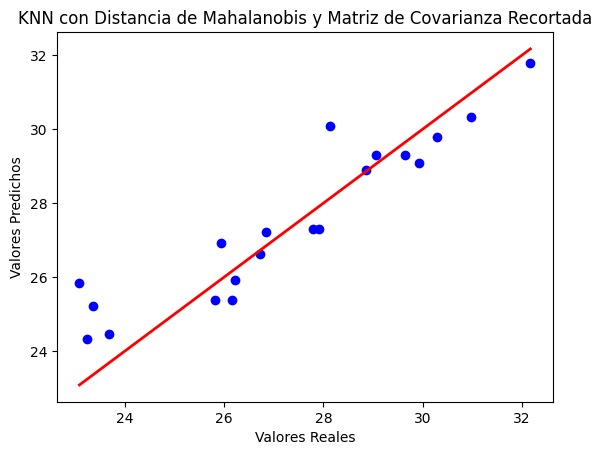

In [13]:
# Matriz de covarianza recortada usando Ledoit-Wolf
lw = LedoitWolf()
lw.fit(X_train_outliers)
cov_matrix_lw = lw.covariance_
cov_matrix_lw_inv_outliers = np.linalg.inv(cov_matrix_lw)

# Implementar KNN usando distancia de Mahalanobis con matriz de covarianza recortada
def knn_mahalanobis(X_train, Y_train, X_test, k, cov_matrix_inv):
    knn_regressor = KNeighborsRegressor(n_neighbors=k, metric='mahalanobis', metric_params={'VI': cov_matrix_lw_inv_outliers})
    knn_regressor.fit(X_train_outliers, Y_train)
    Y_pred = knn_regressor.predict(X_test)
    return Y_pred

# Ajustar el valor de K
k_values = range(1, 71)
best_k = 1
best_score = float('inf')

for k in k_values:
    Y_pred = knn_mahalanobis(X_train_outliers, Y_train, X_test_outliers, k, cov_matrix_lw_inv_outliers)
    mse = mean_squared_error(Y_test, Y_pred)
    if mse < best_score:
        best_score = mse
        best_k = k

# Evaluar el modelo con el mejor K
Y_pred_test = knn_mahalanobis(X_train_outliers, Y_train, X_test_outliers, best_k, cov_matrix_lw_inv)
Y_pred_train = knn_mahalanobis(X_train_outliers, Y_train, X_train_outliers, best_k, cov_matrix_lw_inv)

medae_test = median_absolute_error(Y_test, Y_pred_test1)
medae_train = median_absolute_error(Y_train, Y_pred_train1)

print(f"Mejor valor de K: {best_k}")
print(f"median_absolute_error (Train): {medae_train}")
print(f"median_absolute_error (Test): {medae_test}")

plt.scatter(Y_test, Y_pred_test1, color='blue')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linewidth=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('KNN con Distancia de Mahalanobis y Matriz de Covarianza Recortada')
plt.show()

### Regresión lineal

median_absolute_error train (Regresión Lineal): 1.1176878447709626
median_absolute_error test (Regresión Lineal): 1.7402785716166953


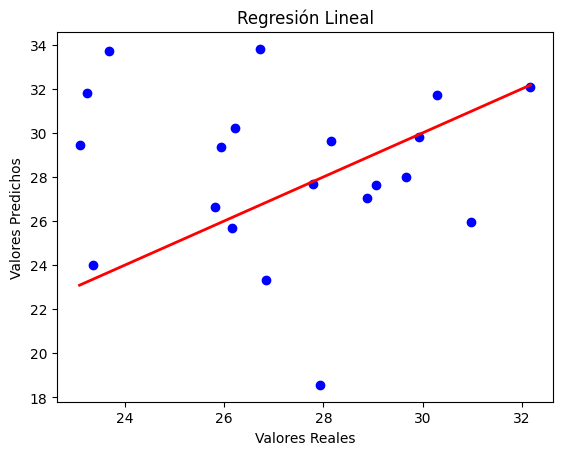

In [14]:
# Ajustar el modelo de regresión lineal
linreg = LinearRegression()
linreg.fit(X_train_outliers, Y_train)
Y_pred_linreg = linreg.predict(X_test_outliers)
X_pred_linreg = linreg.predict(X_train_outliers)

# Evaluar el modelo
medae_test = median_absolute_error(Y_test, Y_pred_linreg)
medae_train = median_absolute_error(Y_train, X_pred_linreg)

# Resultados
print(f"median_absolute_error train (Regresión Lineal): {medae_train}")
print(f"median_absolute_error test (Regresión Lineal): {medae_test}")

# Visualizar los resultados
plt.scatter(Y_test, Y_pred_linreg, color='blue')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linewidth=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Regresión Lineal')
plt.show()

### Regresión Lineal Robusta

median_absolute_error train (Robust): 1.0767427190719001
median_absolute_error test (Robust): 1.7232240665043292


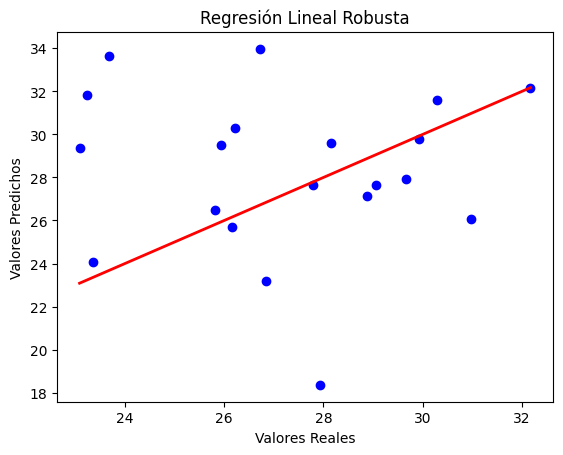

In [15]:
# Agregar una columna de unos para el intercepto en el modelo de regresión
X_train_const = sm.add_constant(X_train_outliers)
X_test_const = sm.add_constant(X_test_outliers)

# Ajustar el modelo de regresión lineal robusta
robust_model = sm.RLM(Y_train, X_train_const, M=sm.robust.norms.HuberT()) # Utilizar el estimador M (Huber) para la regresión
robust_results = robust_model.fit(scale_est=sm.robust.scale.HuberScale())

# Predicciones del modelo
Y_pred_test = robust_results.predict(X_test_const)
Y_pred_train = robust_results.predict(X_train_const)

# Evaluar el modelo robusto
medae_testr = median_absolute_error(Y_test, Y_pred_test)
medae_trainr = median_absolute_error(Y_train, Y_pred_train)

# Resultados
print(f"median_absolute_error train (Robust): {medae_trainr}")
print(f"median_absolute_error test (Robust): {medae_testr}")

# Visualizar los resultados
plt.scatter(Y_test, Y_pred_test, color='blue')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linewidth=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Regresión Lineal Robusta')
plt.show()

# Punto 3

In [16]:
df_c = pd.read_csv("/content/VentasCompacto.csv")
df_suv = pd.read_csv("/content/VentasSUV.csv")

dfc_r1 = df_c.iloc[:100] #region1 compacto
dfc_r2 = df_c.iloc[100:] #region2 compacto
dfsuv_r1 = df_suv.iloc[:150] #region1 SUV
dfsuv_r2 = df_suv.iloc[150:] #region1 SUV

In [17]:
t1 = shapiro(dfc_r1['VentasCompacto']) #region1 compacto
t2 = shapiro(dfc_r2['VentasCompacto']) #region2 compacto
t3 = shapiro(dfsuv_r1['VentasSUV']) #region1 SUV
t4 = shapiro(dfsuv_r2['VentasSUV']) #region2 SUV

t1,t2,t3,t4

(ShapiroResult(statistic=0.992225170135498, pvalue=0.8372894525527954),
 ShapiroResult(statistic=0.9486708641052246, pvalue=1.0476666290060166e-07),
 ShapiroResult(statistic=0.9941461086273193, pvalue=0.8080020546913147),
 ShapiroResult(statistic=0.8566345572471619, pvalue=7.315090044812678e-08))

In [18]:
t_statistic, p_value = stats.ttest_ind(dfc_r1['VentasCompacto'], dfsuv_r1['VentasSUV'], alternative = 'two-sided') # Realizar la prueba t test
stat_r2, p_r2 = mannwhitneyu(dfc_r2['VentasCompacto'], dfsuv_r2['VentasSUV'], alternative = 'two-sided') # Realizar la prueba de Mann-Whitney U

(t_statistic, p_value), (stat_r2, p_r2)

((-6.403701173689345, 7.544993406923015e-10), (9001.0, 0.004917576524162301))

In [19]:
stat_r1s, p_r1s = stats.ttest_ind(dfc_r1['VentasCompacto'], dfsuv_r1['VentasSUV'], alternative='less') # Realizar la prueba t test
stat_r2s, p_r2s = mannwhitneyu(dfc_r2['VentasCompacto'], dfsuv_r2['VentasSUV'], alternative='less') # Realizar la prueba de Mann-Whitney U

(stat_r1s, p_r1s), (stat_r2s, p_r2s)

((-6.403701173689345, 3.7724967034615073e-10), (9001.0, 0.0024587882620811506))

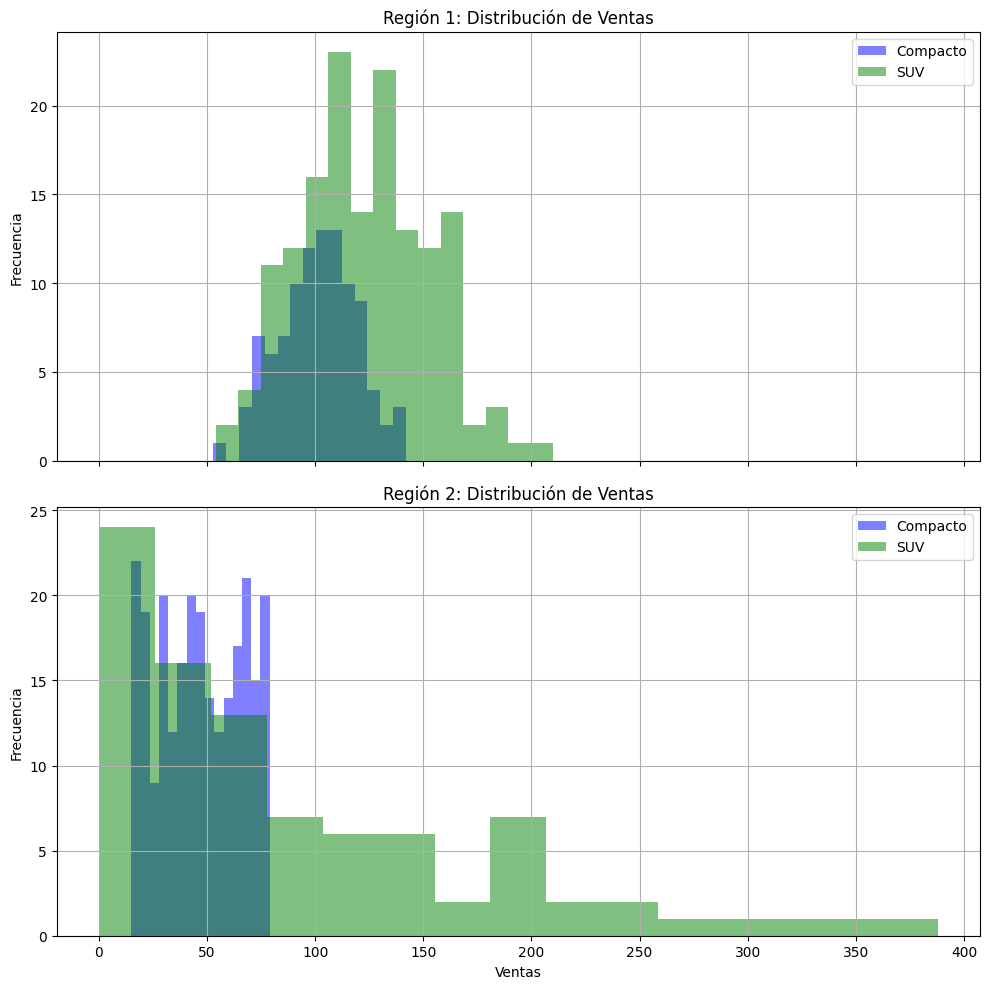

In [20]:
#Histogramas
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
# Región 1
axes[0].hist(dfc_r1['VentasCompacto'], bins=15, alpha=0.5, label='Compacto', color='blue')
axes[0].hist(dfsuv_r1['VentasSUV'], bins=15, alpha=0.5, label='SUV', color='green')
axes[0].set_title('Región 1: Distribución de Ventas')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()
axes[0].grid(True)
# Región 2
axes[1].hist(dfc_r2['VentasCompacto'], bins=15, alpha=0.5, label='Compacto', color='blue')
axes[1].hist(dfsuv_r2['VentasSUV'], bins=15, alpha=0.5, label='SUV', color='green')
axes[1].set_title('Región 2: Distribución de Ventas')
axes[1].set_xlabel('Ventas')
axes[1].set_ylabel('Frecuencia')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Punto 4

In [21]:
#Cargar la encuesta
encuesta = pd.read_csv('/content/encuesta.csv')
viajes_2022 = encuesta['Viajes_2022'].values
viajes_2023 = encuesta['Viajes_2023'].values

# Realizar la prueba de Wilcoxon
stat, p_value = wilcoxon(viajes_2023, viajes_2022, alternative='greater')

# Imprimir el resultado
print("Estadístico de la prueba:", stat)
print("Valor p:", p_value)

# Comprobar si el valor p es menor que el nivel de significancia (α)
nivel_significancia = 0.05
if p_value < nivel_significancia:
    print("Conclusión: Rechazamos la hipótesis nula.")
    print("Hay evidencia suficiente para decir que hay una tendencia a viajar más en 2023 que en 2022.")
else:
    print("Conclusión: No podemos rechazar la hipótesis nula.")
    print("No hay suficiente evidencia para decir que hay una diferencia significativa en el número de viajes entre 2022 y 2023.")


Estadístico de la prueba: 342.0
Valor p: 0.00011482789788043376
Conclusión: Rechazamos la hipótesis nula.
Hay evidencia suficiente para decir que hay una tendencia a viajar más en 2023 que en 2022.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
